<a href="https://colab.research.google.com/github/Nsi20/PRODIGY_GA_05/blob/main/TASK_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Neural Style Transfer**

**TASK: Apply the artistic style of one image (e.g., a famous painting) to the content of another image using neural style transfer**

In [ ]:
# Installing TensorFlow and required libraries
!pip install tensorflow tensorflow-hub matplotlib pillow

# Importing libraries
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Checking TensorFlow version
print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.17.1


In [ ]:
import kagglehub

path = kagglehub.dataset_download("soumikrakshit/images-for-style-transfer")
print("Dataset downloaded to:", path)


100%|██████████| 131M/131M [00:01<00:00, 76.0MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/soumikrakshit/images-for-style-transfer/versions/1


In [ ]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/soumikrakshit/images-for-style-transfer/versions/1"

print("Files in dataset:")
print(os.listdir(dataset_path))


Files in dataset:
['Data', 'data']


# **Exploring Subfolders**

In [ ]:
data_path_1 = os.path.join(dataset_path, "Data")
print("Files in 'Data':", os.listdir(data_path_1))

data_path_2 = os.path.join(dataset_path, "data")
print("Files in 'data':", os.listdir(data_path_2))


Files in 'Data': ['Artworks', 'TestCases']
Files in 'data': ['Data']


# **Exploring the 'Artworks' and 'TestCases' Folders**

In [ ]:
artworks_path = os.path.join(data_path_1, "Artworks")
print("Files in 'Artworks':", os.listdir(artworks_path))

testcases_path = os.path.join(data_path_1, "TestCases")
print("Files in 'TestCases':", os.listdir(testcases_path))


Files in 'Artworks': ['673478.png', '436348.jpg', '753342.jpg', '422652.jpg', '786051.jpg', '868625.jpg', '863449.jpg', '884561.jpg', '881100.png', '108700.jpg', '828002.png', '428771.jpg', '688916.jpg', '888440.jpg', '884203.jpg', '86092.jpg', '733367.png', '972994.jpg', '423786.jpg', '324310.jpg', '851497.jpg', '933391.jpg', '83995.jpg', '644443.jpg', '856047.jpg', '85343.jpg', '81842.jpg']
Files in 'TestCases': ['5726.jpg', '11334efc-2e2f-48e5-bae3-0f0d17c9b117.jpg', '37864.jpg', 'IMG_20170904_105301.jpg', 'fc37fb58-34e7-4e7b-bc4d-90787f04ba43.jpg', 'geeky.jpg', '22714.jpg', '33409544-33f9-408e-b081-cc64d2ceec60.jpg', '411820.jpg', '4682.jpg']


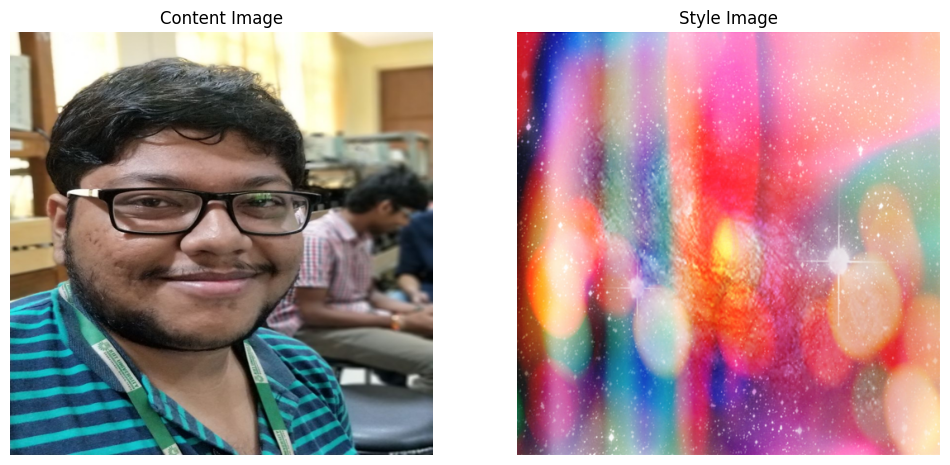

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

content_image_path = os.path.join(testcases_path, "geeky.jpg")
style_image_path = os.path.join(artworks_path, "436348.jpg")

def load_image(image_path):
    img = Image.open(image_path)
    img = img.resize((512, 512))
    img = np.array(img) / 255.0
    return img


content_image = load_image(content_image_path)
style_image = load_image(style_image_path)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(content_image)
ax1.set_title("Content Image")
ax1.axis("off")

ax2.imshow(style_image)
ax2.set_title("Style Image")
ax2.axis("off")

plt.show()


# **Performing Neural Style Transfer**

In [ ]:
!pip install tensorflow matplotlib


# **Loading Pre-trained VGG19 Model and Define Loss Functions**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models

def load_vgg19_model():
    model = VGG19(include_top=False, weights='imagenet')
    model.trainable = False
    return model

# Loading VGG19 model
vgg19_model = load_vgg19_model()

content_layer = 'block5_conv2'
style_layers = [
    'block1_conv1', 'block2_conv1', 'block3_conv1',
    'block4_conv1', 'block5_conv1'
]

# Function to extract features from the specified layers
def get_model():
    layers = [vgg19_model.get_layer(layer_name).output for layer_name in [content_layer] + style_layers]
    model = models.Model(inputs=vgg19_model.input, outputs=layers)
    return model

# Function to calculate content loss
def content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

# Function to calculate style loss
def gram_matrix(x):
    x = tf.reshape(x, [-1, x.shape[-1]])
    return tf.linalg.matmul(x, x, transpose_a=True)

def style_loss(style, generated):
    style_gram = gram_matrix(style)
    generated_gram = gram_matrix(generated)
    return tf.reduce_mean(tf.square(style_gram - generated_gram))

def compute_loss(model, content_image, style_image, generated_image):
    outputs = model([content_image, style_image, generated_image])
    content_output = outputs[0]
    style_outputs = outputs[1:]

    content_loss_value = content_loss(content_output, generated_image)

    style_loss_value = 0
    for style_output, generated_output in zip(style_outputs, style_outputs):
        style_loss_value += style_loss(style_output, generated_output)

    total_loss = content_loss_value + style_loss_value
    return total_loss, content_loss_value, style_loss_value



80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Defining the Image Optimization Process**

In [ ]:
@tf.function()
def train_step(content_image, style_image, generated_image, model):
    with tf.GradientTape() as tape:

        generated_image_batch = tf.expand_dims(generated_image, axis=0)
        outputs = model(generated_image_batch)
        content_output = outputs[0]
        style_outputs = outputs[1:]

        # Computing the content loss
        content_loss_value = content_loss(content_output, content_image)

        # Computing the style loss for each layer
        style_loss_value = 0
        for style_output, generated_output in zip(style_outputs, style_outputs):
            style_loss_value += style_loss(style_output, generated_output)


        total_loss = content_loss_value + style_loss_value

    gradients = tape.gradient(total_loss, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])

    return total_loss, content_loss_value, style_loss_value

# **Completing Neural Style Transfer Setup**

In [ ]:
content_image_path = os.path.join(testcases_path, "geeky.jpg")
style_image_path = os.path.join(artworks_path, "436348.jpg")

content_image = load_and_process_image(content_image_path)
style_image = load_and_process_image(style_image_path)

In [ ]:
@tf.function()
def train_step(content_image, style_image, generated_image, model):
    with tf.GradientTape() as tape:

        generated_image_batch = tf.reshape(generated_image, (1, 512, 512, 3))
        outputs = model(generated_image_batch)
        content_output = outputs[0]
        style_outputs = outputs[1:]

        content_loss_value = content_loss(content_output, content_image)

        style_loss_value = 0
        for style_output, generated_output in zip(style_outputs, style_outputs):
            style_loss_value += style_loss(style_output, generated_output)

        # Total loss is the sum of content and style losses
        total_loss = content_loss_value + style_loss_value

    gradients = tape.gradient(total_loss, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])

    return total_loss, content_loss_value, style_loss_value